In [1]:
# %reset
# %load_ext autoreload
# %autoreload 2

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from info.utils.pdf_computer import pdfComputer
from info.models.logistic_network import Logistic
from info.utils.causal_network import search_mpid_condition, causal_network
from info.utils.others import reorganize_data
from info.core.info import info

# %matplotlib inline

In [2]:
# The number of bins in each dimension
n1, n2, n3 = 10, 25, 30

# Settings for plot
plt.rcParams["figure.figsize"] = (5,4)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Generate the variable values
lag  = 1
e    = 1.
ez   = .2
# n    = 2
# adjM = np.array([[0, 0], [1, 0]])
# lagM = np.array([[0, 0], [lag, 0]])
n    = 3
adjM = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
lagM = np.array([[0, lag, lag], [lag, 0, lag], [lag, lag, 0]])

# Parameters for simulation
nstep = 1000
noiseType = 'additive'
noiseDist = 'uniform'
noiseOn   = [1, 1, 1]
noisePara = [1, 0, 1]

# Define the corresponding causalDict
causalDict = {0: [(1,-1), (2,-1)],
              1: [(0,-1), (2,-1)],
              2: [(0,-1), (1,-1)]}
taumax=5
sidepath=False
verbosity=1

# Initialize the causal network based on causalDict
network=causal_network(causalDict, taumax)

# Generate the outputs
logistic = Logistic(n, adjM, lagM, e, ez, noiseType=noiseType, 
                    noiseDist=noiseDist, noisePara=noisePara)
results = logistic.simulate(nstep)
# d1, d2, d3 = results[0,:], results[1,:], results[2,:]

# Plot
# t = range(nstep)
# # plt.plot(t, results[0, :], 'b')
# # plt.plot(t, results[1, :], 'k')
# plt.plot(d1[:-lag],d2[lag:],'.')
# plt.title('Time series data')
# plt.xlabel('x1(t-1)')
# plt.ylabel('x2(t)')
# plt.show()
# # Save
# np.savetxt('data.csv',results,delimiter=',')

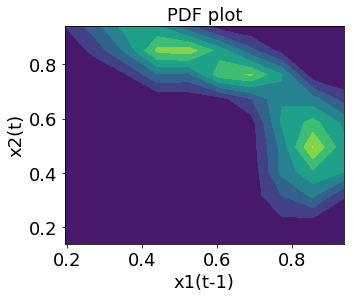

,ordinary,norm_p,norm_m
H(X),3.074549,NaN,NaN
H(X|Y),2.133582,0.414370,0.707561
H(Y),3.015401,NaN,NaN
H(Y|X),2.074434,NaN,NaN
I(X;Y),0.940967,0.182748,0.312054


In [4]:
# 2D -- unconditioned
# Define the two sources and the target
source, target = (0, -1), (1, 0)

# Reorganize the data
results1 = reorganize_data(results.T, [source, target])

# # Rearrange the results with the lag
# lag1 = 1
# results1 = np.array([d1[:-lag1],d2[lag1:]]).T

# Calculate the PDF
pdfsolver1 = pdfComputer(ndim=2, approach='kde_c', 
                         bandwidth='silverman', kernel='epanechnikov', base=2)
_, pdf1, cd = pdfsolver1.computePDF(results1, nbins=[n1] * 2)

# Plot
xv, yv = np.meshgrid(cd[0], cd[1], indexing='ij')
plt.contourf(xv, yv, pdf1)
plt.title('PDF plot')
plt.xlabel('x1(t-1)')
plt.ylabel('x2(t)')
plt.show()

# Calculate the INFO
test1_info = info(ndim=2, pdfs=pdf1)
test1_info.normalizeinfo()
test1_info.allInfo

[(2, -2), (2, -1), (1, -2)]


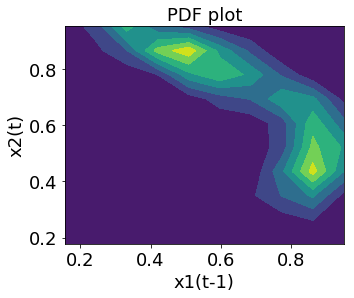

,ordinary,norm_p,norm_m
H(X),3.004583,NaN,NaN
H(X|Y),2.029355,NaN,NaN
"H(X|Y,W)",0.836200,0.360657,0.273613
I(X;Y|W),0.393882,0.169883,0.128882


In [10]:
# 2D -- conditioned
# Define the two sources and the target
source, target = (0, -1), (1, 0)

# Generate the conditions for MIT
w = network.search_mit_condition(source, target, sidepath=sidepath, verbosity=verbosity)
print w

# Reorganize the data
results1 = reorganize_data(results.T, [source, target]+w)
# # Rearrange the results with the lag
# lag1 = 1
# results1 = np.array([d1[:-lag1],d2[lag1:]]).T

# Calculate the PDF
pdfsolver1 = pdfComputer(ndim='m', approach='kde_c', 
                         bandwidth='silverman', kernel='epanechnikov', base=2)
_, pdf1, cd = pdfsolver1.computePDF(results1, nbins=[n1]*(2+len(w)))

# Plot
xv, yv = np.meshgrid(cd[0], cd[1], indexing='ij')
plt.contourf(xv, yv, np.sum(pdf1, axis=tuple(range(2,len(w)+2))))
plt.title('PDF plot')
plt.xlabel('x1(t-1)')
plt.ylabel('x2(t)')
plt.show()

# Calculate the INFO
test1_info = info(ndim=2, pdfs=pdf1, conditioned=True)
test1_info.normalizeinfo()
test1_info.allInfo

In [6]:
# 3D -- unconditioned
# Define the two sources and the target
source1, source2 = (0, -1), (1, -1)
target = (2, 0)

# Reorganize the data
results2 = reorganize_data(results.T, [source1, source2, target])
# # Rearrange the results with the lag
# X, Y, Z = d1[:-lag]*.5, d2[:-lag], d3[lag:]
# results2 = np.array([X, Y, Z]).T

# Calculate the PDF
pdfsolver2 = pdfComputer(ndim=3, approach='kde', bandwidth='silverman', kernel='epanechnikov')
_, pdf2, cd = pdfsolver2.computePDF(results2, nbins=[n1] * 3)
# xv, yv = np.meshgrid(cd[0], cd[2], indexing='ij')
# plt.contourf(xv, yv, np.sum(pdf2,axis=(1)))

# Calculate the INFO
test2_info = info(ndim=3, pdfs=pdf2)
test2_info.normalizeinfo()
test2_info.allInfo

# Plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X, Y, Z)
# ax.set_xlabel('x2(t-1)')
# ax.set_ylabel('x1(t-1)')
# ax.set_zlabel('x2(t)')
# plt.show()

,ordinary,norm_p,norm_m
I(X;Z),1.070514,0.155360,0.348744
I(Y;Z),1.011888,0.146851,0.329645
"I(X,Y;Z)",1.414819,0.205327,0.460909
II,-0.667583,-0.096884,-0.217480
"R(Z;Y,X)",0.767845,0.111434,0.250143
"S(Z;Y,X)",0.100263,0.014551,0.032663
"U(Z,X)",0.302669,0.043925,0.098601
"U(Z,Y)",0.244043,0.035417,0.079502
Rmin,0.667583,0.096884,0.217480
Isource,0.291203,0.042261,0.094866


In [11]:
# 3D -- conditioned
# Define the two sources and the target
source1, source2 = (0, -1), (1, -1)
target = (2, 0)

# # Rearrange the results with the lag
# X, Y, Z = d1[:-lag]*.5, d2[:-lag], d3[lag:]
# results2 = np.array([X, Y, Z]).T

# Generate the conditions for MPID
w = network.search_mpid_condition(source1, source2, target, sidepath=sidepath, verbosity=verbosity)
print w

# Reorganize the data
results22 = reorganize_data(results.T, [source1, source2, target] + w)
# results22 = reorganize_data(results.T, [source1, source2, target])    
print results22.shape

# Calculate the PDF
pdfsolver22 = pdfComputer(ndim='m', approach='kde', bandwidth='silverman', kernel='epanechnikov')
_, pdf22, cd = pdfsolver22.computePDF(results22, nbins=[n1]*(3+len(w)))
# xv, yv = np.meshgrid(cd[0], cd[2], indexing='ij')
# plt.contourf(xv, yv, np.sum(pdf2,axis=(1)))

# Calculate the INFO
test22_info = info(ndim=3, pdfs=pdf22, conditioned=True)
test22_info.normalizeinfo()
test22_info.allInfo

# Plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X, Y, Z)
# ax.set_xlabel('x2(t-1)')
# ax.set_ylabel('x1(t-1)')
# ax.set_zlabel('x2(t)')
# plt.show()

[(2, -2), (0, -2), (1, -2)]
(998, 6)


,ordinary,norm_p,norm_m
I(X;Z|W),0.478588,0.415625,0.155469
I(Y;Z|W),0.484417,0.420688,0.157363
"I(X,Y;Z|W)",0.677503,0.588371,0.220086
II,-0.285502,-0.247941,-0.092745
"R(Z;Y,X|W)",0.297936,0.258739,0.096784
"S(Z;Y,X|W)",0.012434,0.010798,0.004039
"U(Z,X|W)",0.180652,0.156886,0.058685
"U(Z,Y|W)",0.186482,0.161948,0.060578
Rmin,0.285502,0.247941,0.092745
Isource,0.064395,0.055923,0.020919


In [11]:
rdinary	norm_p	norm_m
I(X;Z|W)	0.531426	0.391883	0.173016
I(Y;Z|W)	0.539824	0.398076	0.175750
I(X,Y;Z|W)	0.781125	0.576016	0.254310
II	-0.290126	-0.213944	-0.094456
R(Z;Y,X|W)	0.306166	0.225772	0.099678
S(Z;Y,X|W)	0.016040	0.011828	0.005222
U(Z,X|W)	0.225261	0.166111	0.073338
U(Z,Y|W)	0.233659	0.172304	0.076072
Rmin	0.290126	0.213944	0.094456
Isource	0.066474	0.049019	0.021642
RMMI	0.531426	0.391883	0.173016

[(0, -1)]

In [9]:
# from scipy.stats import entropy
# import sklearn.metrics as me
# def mi(pdf, base=2):
#     xpdf = np.sum(pdf, axis=1)
#     ypdf = np.sum(pdf, axis=0)
    
#     return entropy(xpdf,base=base)+entropy(ypdf,base=base)- \
#            entropy(pdf.reshape(pdf.size),base=base)
    
# base=np.e
# print me.mutual_info_score(d1[:-lag], d2[lag:])
# pdfsolver1 = pdfComputer(ndim=2, approach='kde', 
#                          bandwidth='silverman', kernel='epanechnikov')
# _, pdf1, cd = pdfsolver1.computePDF(results1)
# test1_info = info(pdf1, base=base)
# print test1_info.allInfo
# print mi(pdf1, base=base)

# labels_a = np.array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])
# labels_b = np.array([1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 3, 1, 3, 3, 3, 2, 2])
# results3 = np.array([labels_a, labels_b]).T
# print me.mutual_info_score(labels_a, labels_b)
# pdfsolver1 = pdfComputer(ndim=2, approach='kde', 
#                          bandwidth='silverman', kernel='epanechnikov')
# _, pdf1, cd = pdfsolver1.computePDF(results3)
# test1_info = info(pdf1, base=base)
# print test1_info.allInfo
# print mi(pdf1, base=base)